# Capstone Project --- DS C10

#                                 CREDIT CARD FRAUD DETECTION 

Although digital transactions in India registered a 51% growth in 2018-19, 
their safety remains a concern. 
Fraudulent activities have increased severalfold, with around 52,304 cases of credit/debit card fraud reported in FY'19 alone. 
Due to this steep increase in banking frauds, it is the need of the hour to detect these fraudulent transactions in time in order to help consumers as well as banks, 
who are losing their credit worth each day. Machine learning can play a vital role in detecting fraudulent transactions.



in order to meet above mentioned requirement we have built a machine learning model capable of detecting fraudulent transactions. 
we have also excecuted methods to handle class imbalances present in data set, along with model selection and hyperparameter tuning.

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing


import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [9]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
seed =45


# Exploratory data analysis

In [10]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


checking the data

In [11]:
print("Credit Card Fraud Detection data -  rows:",df.shape[0]," columns:", df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


observing the Time feature, we can see that the data contains 284,807 transactions, during 2 consecutive days (or 172792 seconds).

Check missing data

Let's check if there is any missing data

In [13]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


hence we can say that there is no missing data in the entire dataset.

# Data Imbalance Visualization using Plotly

In [14]:
temp = df["Class"].value_counts()
df1 = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df1['Class'],y = df1['values'],
    name="Credit Card Fraud Class - data Imbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df1['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data Imbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

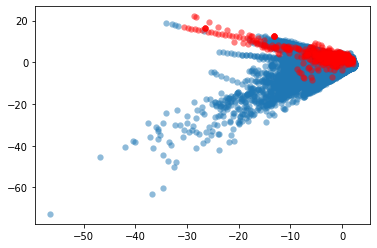

In [15]:
# Plot how fraud and non-fraud cases are scattered 
plt.scatter(df.loc[df['Class'] == 0]['V1'], df.loc[df['Class'] == 0]['V2'], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.loc[df['Class'] == 1]['V1'], df.loc[df['Class'] == 1]['V2'], label="Class #1", alpha=0.5, linewidth=0.15,c='r')
plt.show()

# Dataset Summary:

1.We have 284807 entries within 30 features and 1 target (Class).

2.There are no "Null" values, so no need to work on ways to replace values.

3.The mean of all the mounts made is relatively small, approximately USD 88.

4.Most of the transactions were Non-Fraud (99.83%) of the time, while Fraud transactions occurs (017%) of the time in the dataframe.


5.Only 492 (or 0.172%) of transaction are fraudulent. That means the data is highly unbalanced with respect with target variable Class.

# Data Exploration using Plotly

Transactions in time

In [16]:
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]
#plt.figure(figsize = (14,4))
#plt.title('Credit Card Transactions Time Density Plot')
#sns.set_color_codes("pastel")
#sns.distplot(class_0,kde=True,bins=480)
#sns.distplot(class_1,kde=True,bins=480)
#plt.show()
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

# Fraudulent transactions have a distribution more even than valid transactions  and  


# are equaly distributed in time, having low real transaction times, during night in Europe timezone.

Transactions amount


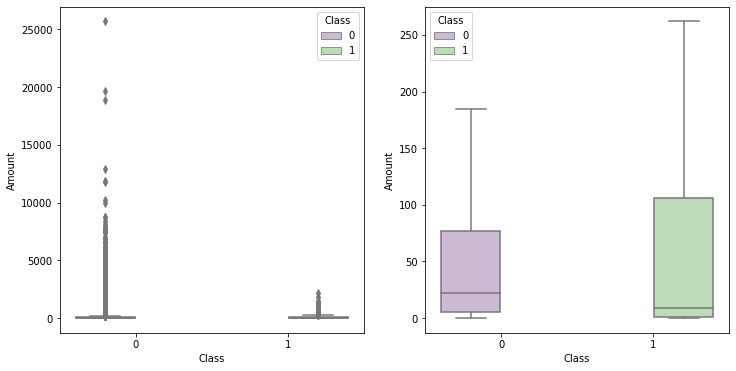

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df, palette="PRGn",showfliers=False)
plt.show();

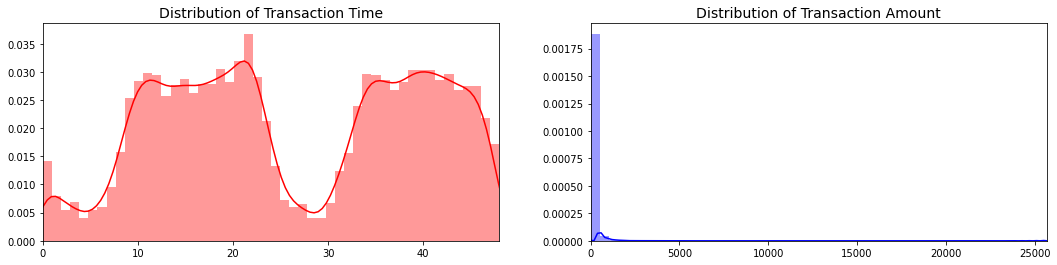

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Plot the distribution of 'Time' feature 
sns.distplot(df['Time'].values/(60*60), ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Time', fontsize=14)
ax[0].set_xlim([min(df['Time'].values/(60*60)), max(df['Time'].values/(60*60))])

sns.distplot(df['Amount'].values, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Amount', fontsize=14)
ax[1].set_xlim([min(df['Amount'].values), max(df['Amount'].values)])

plt.show()

In [19]:
copy = df[['Amount','Class']].copy()
class_0 = copy.loc[copy['Class'] == 0]['Amount']
class_1 = copy.loc[copy['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [20]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

# Inferences::

The real transaction have a smaller mean value, larger Q1, smaller Q3 and Q4 and larger outliers; 

fraudulent transactions have a smaller Q1 , larger Q4 and smaller outliers.




Let's plot the fraudulent transactions (amount) against time. 

The time is shown is seconds from the start of the time period (totaly 48h, over 2 days).

# Fraudulent transactions (amount) against time using Plotly

In [21]:
fraud = df.loc[df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

In [22]:
# Seperate total data into non-fraud and fraud cases
df_nonfraud = df[df.Class == 0] #save non-fraud df observations into a separate df
df_fraud = df[df.Class == 1] #do the same for frauds

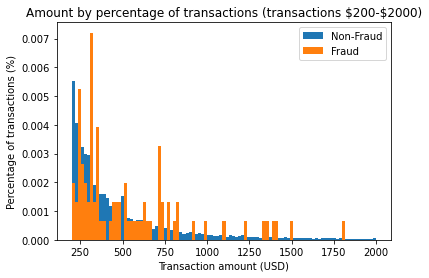

In [23]:
# Plot of high value transactions($200-$2000)
bins = np.linspace(200, 2000, 100)
plt.hist(df_nonfraud.Amount, bins, alpha=1, density=True, label='Non-Fraud')
plt.hist(df_fraud.Amount, bins, alpha=1, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Amount by percentage of transactions (transactions \$200-$2000)")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

# Summary:

1.In the long tail, fraud transaction happened more frequently.

2.It seems It would be hard to differentiate fraud from normal transactions by transaction amount alone.

Transaction Hour

Now we will Look at the transaction percentage from day 0 to the next day.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



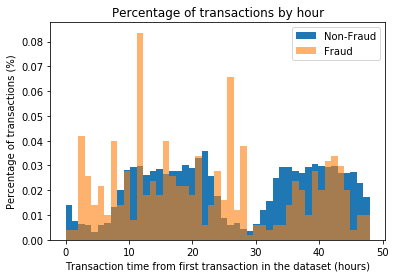

In [17]:
# Plot of transactions in 48 hours
bins = np.linspace(0, 48, 48) #48 hours
plt.hist((df_nonfraud.Time/(60*60)), bins, alpha=1, normed=True, label='Non-Fraud')
plt.hist((df_fraud.Time/(60*60)), bins, alpha=0.6, normed=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)")
plt.show()

Hour "zero" corresponds to the hour the first transaction happened and not necessarily 12-1 AM. Given the heavy decrease in normal transactions from hours 1 to 8 and again roughly at hours 24 to 32, 

it seems fraud tends to occur at higher rates during the night.

#Transaction Amount vs Hour

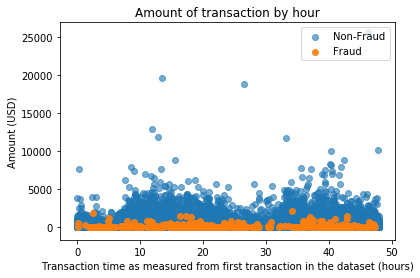

In [18]:
# Plot of transactions in 48 hours
plt.scatter((df_nonfraud.Time/(60*60)), df_nonfraud.Amount, alpha=0.6, label='Non-Fraud')
plt.scatter((df_fraud.Time/(60*60)), df_fraud.Amount, alpha=0.9, label='Fraud')
plt.title("Amount of transaction by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel('Amount (USD)')
plt.legend(loc='upper right')
plt.show()

It is not enough to make a good classifier. 

For example, it would be hard to draw a line that cleanly separates fraud and non-fraud transactions.

# Feature Scaling for non-PCA Transformed features

Features V1-V28 have been transformed by PCA and scaled already. Whereas feature "Time" and "Amount" have not. And considering that we will analyze these two features with other V1-V28, they should better be scaled before we train our model using various algorithms.

-- The Standard Scaler is not recommended as "Time" and "Amount" features are not normally distributed.

-- The Min-Max Scaler is also not recommende as there are noticeable outliers in feature "Amount".

-- The Robust Scaler are robust to outliers: (xi–Q1(x))/( Q3(x)–Q1(x)) (Q1 and Q3 represent 25% and 75% quartiles). So we choose Robust Scaler to scale these two features


In [19]:
# Scale "Time" and "Amount"
from sklearn.preprocessing import StandardScaler, RobustScaler
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

# Make a new dataset named "df_scaled" dropping out original "Time" and "Amount"
df_scaled = df.drop(['Time','Amount'],axis = 1,inplace=False)
df_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


So we will choose Robust Scaler to scale these two features.

# Features correlation with Imbalanced Data

Text(0.5, 1, 'Imbalanced Correlation Matrix')

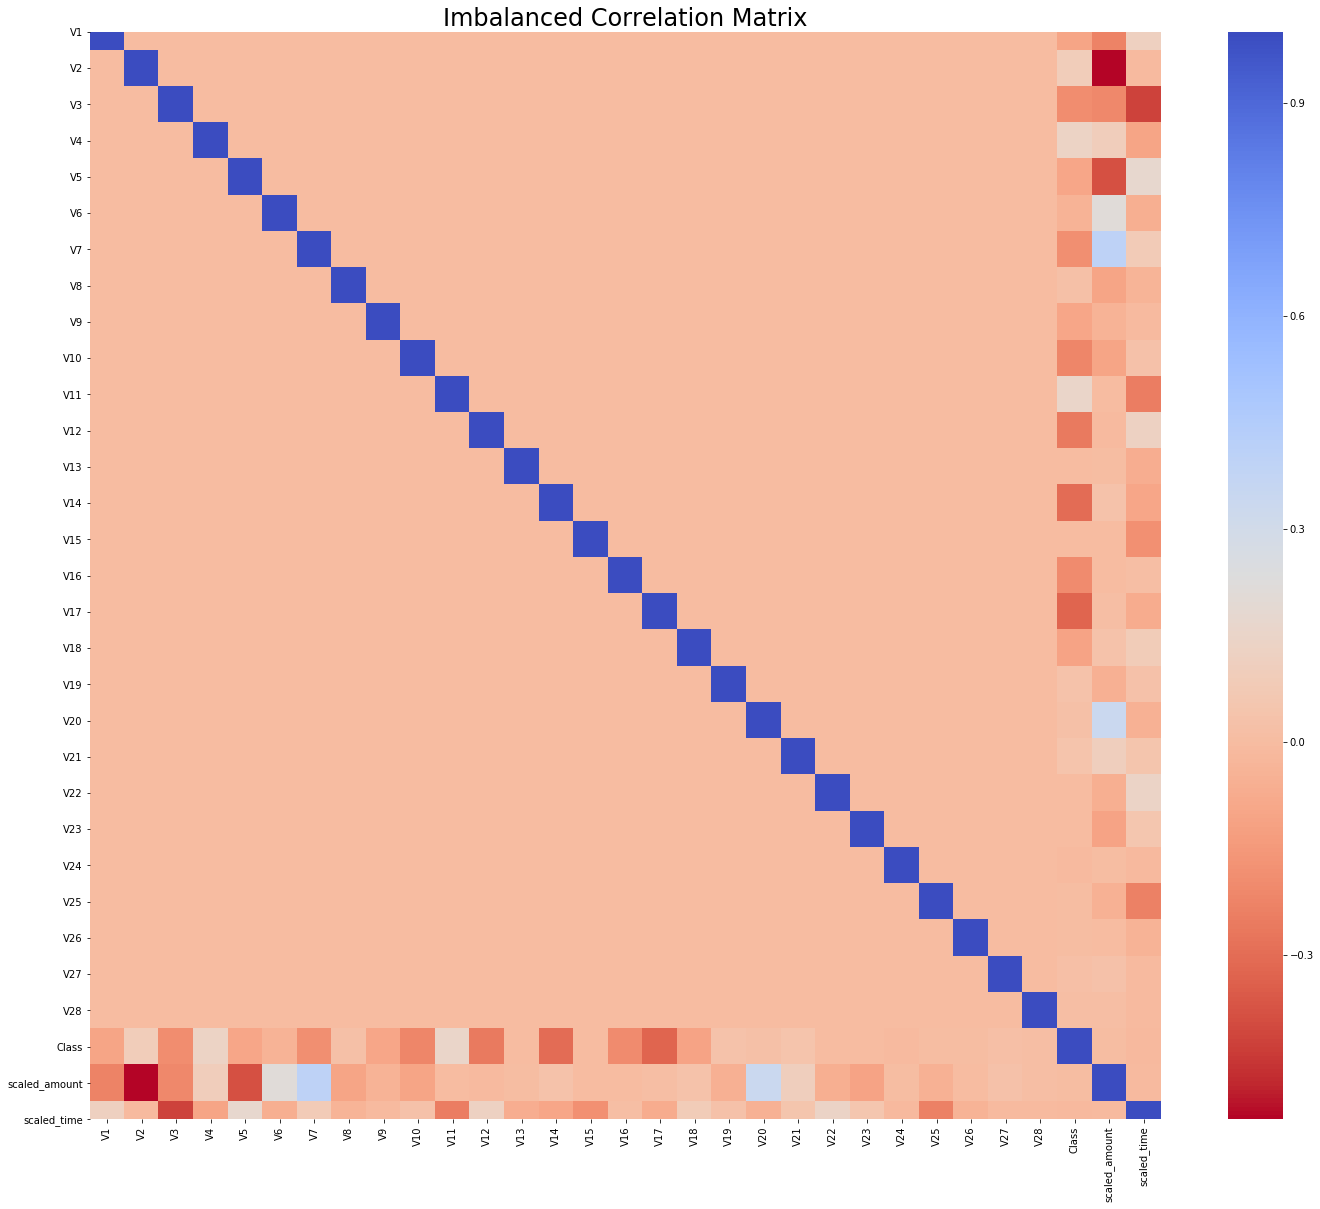

In [20]:
# Calculate pearson correlation coefficience
corr = df_scaled.corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
ax.set_title("Imbalanced Correlation Matrix", fontsize=24)



As expected, there is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse correlation with V3) and Amount (direct correlation with V7 and V20, inverse correlation with V1 and V5).

Let's plot the correlated and inverse correlated values on the same graph.

Let's start with the direct correlated values: {V20;Amount} and {V7;Amount}.


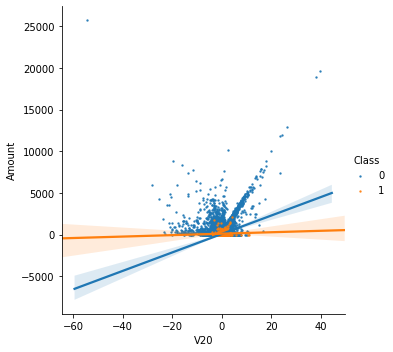

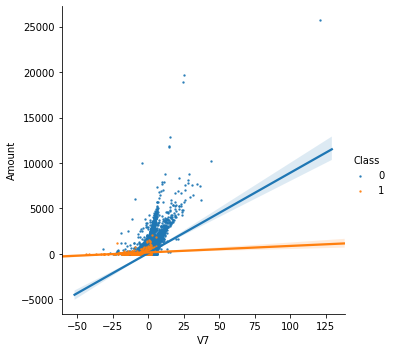

In [21]:
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()



We can confirm that the two couples of features are correlated (the regression lines for Class = 0 have a positive slope, whilst the regression line for Class = 1 have a smaller positive slope).

Let's plot now the inverse correlated values.


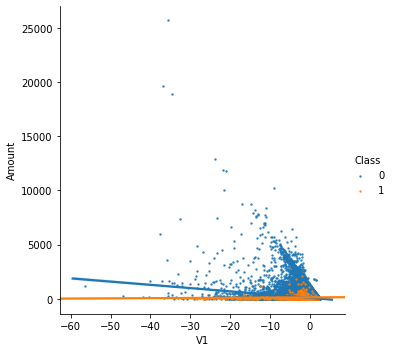

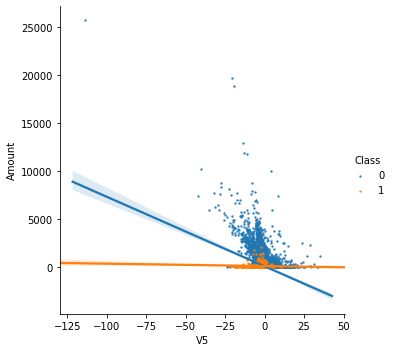

In [22]:
s = sns.lmplot(x='V1', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for Class = 0 have a negative slope while the regression lines for Class = 1 have a very small negative slope).

# Features density plot

ValueError: num must be 1 <= num <= 28, not 29

<Figure size 432x288 with 0 Axes>

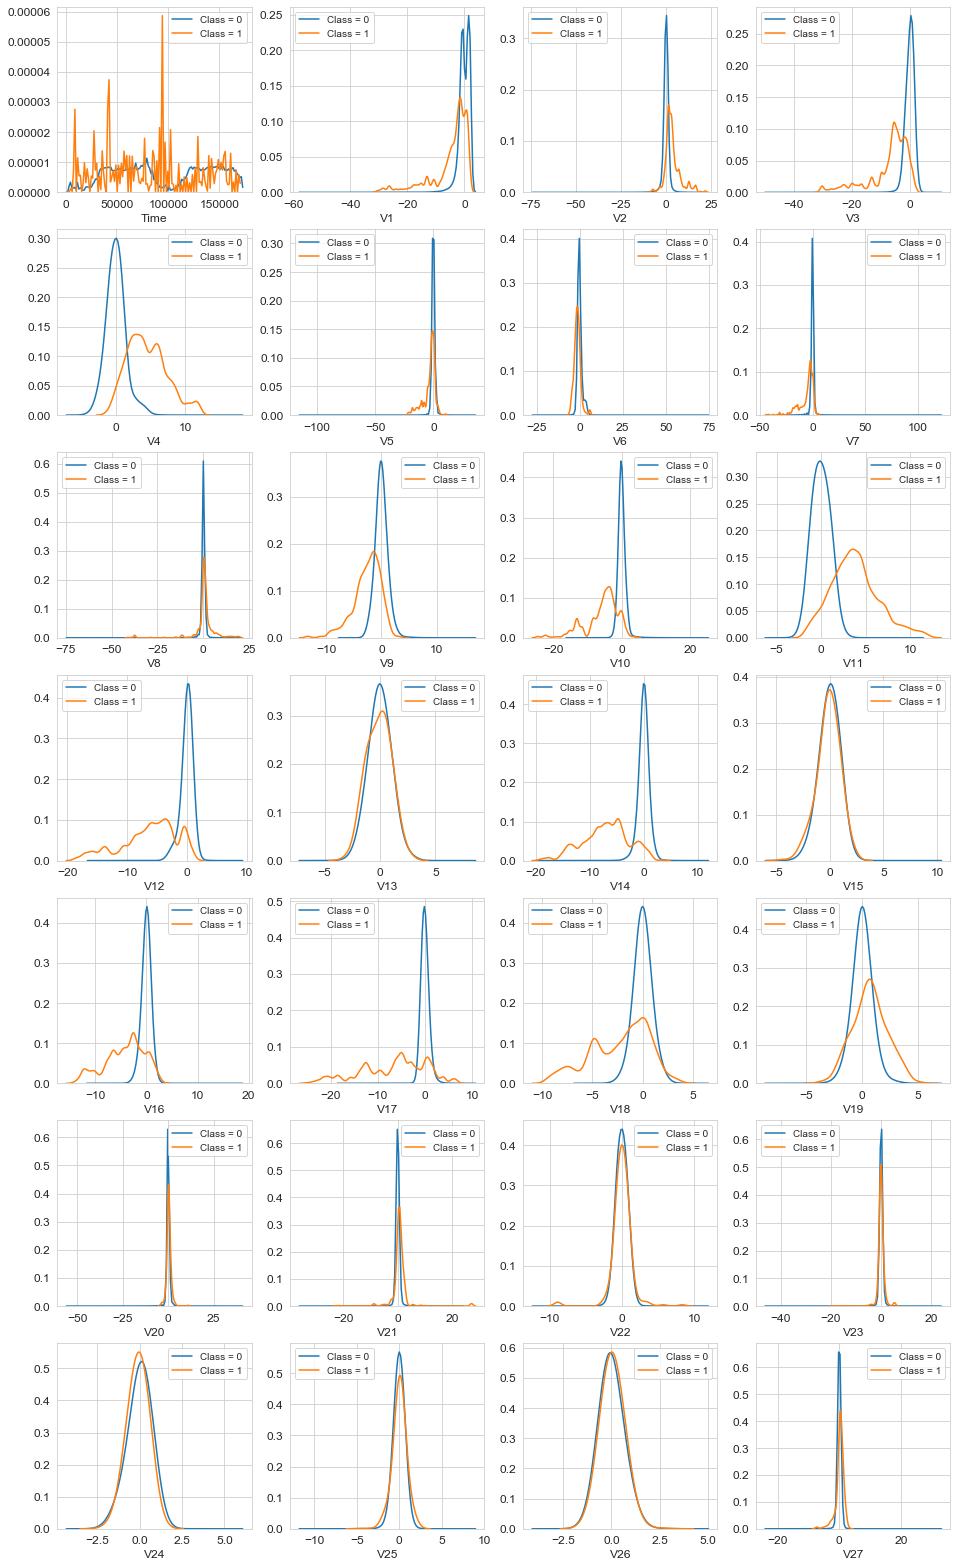

In [23]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(7,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();



For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V25, V26, V28 have similar profiles for the two values of Class.

In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.


# Resampling for Imbalanced Data

--Extracting features from our scaled dataset "df_scaled"


# Define X and y

In [46]:
#Separating dependant variable with independant variables and then dropping it.

X = df_scaled.drop(['Class'], axis=1)
y = df_scaled['Class']

df_scaled.drop('Class', axis=1, inplace=True)

# -- Resample data with RUS, ROS and SMOTE

In [47]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline # Inorder to avoid testing model on sampled data

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# # Oversampling and balancing using SMOTE
undersam = RandomUnderSampler(random_state=0)
oversam = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=42)
borderlinesmote = BorderlineSMOTE(random_state=42)

# resample the training data
X_undersam, y_undersam = undersam.fit_sample(X_train,y_train)
X_oversam, y_oversam = oversam.fit_sample(X_train,y_train)
X_smote, y_smote = smote.fit_sample(X_train,y_train)
X_borderlinesmote, y_borderlinesmote = borderlinesmote.fit_sample(X_train,y_train)

# Handling Skewness

In [48]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

In [49]:
pt = preprocessing.PowerTransformer(copy=False)
trans_X = pt.fit_transform(X)

# Logistic Regression

We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:


    Accuracy = (TP+TN)/total
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)


Predictions on test set and plotting confusion matrix

In [50]:
# Splitting dataset into test and train sets in 70:30 ratio
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trans_X, y, test_size=0.3, train_size=0.7, random_state=1)



In [51]:
#checking Imbalance in data
#As we have already calculated imbalance in our original dataset and now verifying in the splits dataset
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Train data Imbalance: ", y_train_imb)
print("Test data Imbalance: ", y_test_imb)

X_train Shape :  (199364, 30)
X_test Shape :  (85443, 30)
Train data Imbalance:  0.0017939067469988493
Test data Imbalance:  0.0015825010550007033


# Building the Model

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(trans_X, y, test_size=.3, random_state=0)

# Fit a logistic regression model to our data
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtain model predictions
y_predicted = model.predict(X_test)

In [53]:
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

ROC AUC Score: 0.9785543930571665
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.61      0.73       147

    accuracy                           1.00     85443
   macro avg       0.95      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85285    11]
 [   57    90]]


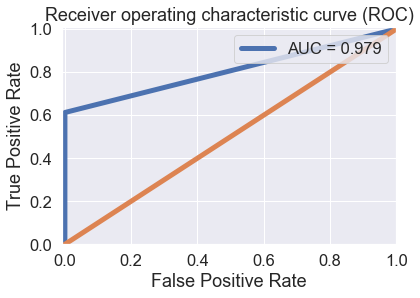

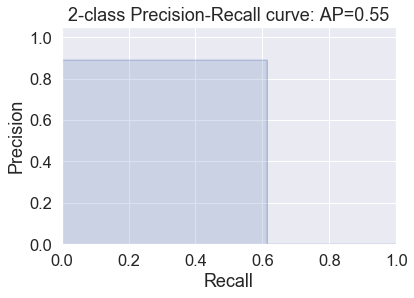

In [54]:
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)

# Calculate Area Under the Receiver Operating Characteristic Curve 
probs = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, probs[:, 1])
print('ROC AUC Score:',roc_auc)

# Obtain precision and recall 
precision, recall, thresholds = precision_recall_curve(y_test, y_predicted)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Define a roc_curve function
def plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1], linewidth=5)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    plt.legend(loc='upper right')
    plt.title('Receiver operating characteristic curve (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define a precision_recall_curve function
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_predicted))

# Plot the roc curve 
plot_roc_curve(false_positive_rate,true_positive_rate,roc_auc)

# Plot recall precision curve
plot_pr_curve(recall, precision, average_precision)

-- Accuracy score= 99.92% which is higher than the baseline 99.83%.

-- Precision = 91/(12+91) = 0.88. The rate of true positive in all positive cases.

-- Recall = 91/ (56+91) = 0.62. The rate of true positive in all true cases.

-- F1-score = 0.73

-- False positives cases = 12


# Logistic Regression with Resampled Data

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(trans_X, y, test_size=.3, random_state=0)

# Resample your training data
rus = RandomUnderSampler()
ros = RandomOverSampler()
smote = SMOTE(random_state=5)
blsmote = BorderlineSMOTE(random_state=5)

X_train_rus, y_train_rus = rus.fit_sample(X_train,y_train)
X_train_ros, y_train_ros = ros.fit_sample(X_train,y_train)
X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train)
X_train_blsmote, y_train_blsmote = blsmote.fit_sample(X_train,y_train)

# Fit a logistic regression model to our data
rus_model = LogisticRegression().fit(X_train_rus, y_train_rus)
ros_model = LogisticRegression().fit(X_train_ros, y_train_ros)
smote_model = LogisticRegression().fit(X_train_smote, y_train_smote)
blsmote_model = LogisticRegression().fit(X_train_blsmote, y_train_blsmote)

y_rus = rus_model.predict(X_test)
y_ros = ros_model.predict(X_test)
y_smote = smote_model.predict(X_test)
y_blsmote = blsmote_model.predict(X_test)

print('Classifcation report:\n', classification_report(y_test, y_rus))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_rus))
print('*'*25)

print('Classifcation report:\n', classification_report(y_test, y_ros))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_ros))
print('*'*25)

print('Classifcation report:\n', classification_report(y_test, y_smote))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_smote))
print('*'*25)

print('Classifcation report:\n', classification_report(y_test, y_blsmote))
print('Confusion matrix:\n', confusion_matrix(y_true = y_test, y_pred = y_blsmote))
print('*'*25)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     85296
           1       0.04      0.93      0.08       147

    accuracy                           0.96     85443
   macro avg       0.52      0.94      0.53     85443
weighted avg       1.00      0.96      0.98     85443

Confusion matrix:
 [[82215  3081]
 [   11   136]]
*************************
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.06      0.92      0.12       147

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443

Confusion matrix:
 [[83233  2063]
 [   12   135]]
*************************
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     85296
           1    

# Imp Point

We can see recall value has been increased in balanced data which is a good sign.

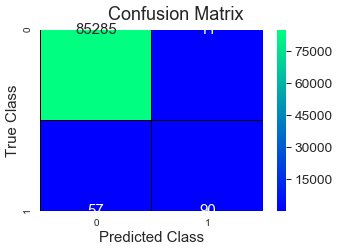

In [56]:
cm = confusion_matrix(y_test, y_predicted)
sns.set(font_scale=1.5) #Adjust to fit
plt.figure(dpi=60)
sns.heatmap(cm,annot=True,fmt='d', cmap='winter',linecolor='black',linewidths=0.2)
plt.ylabel('True Class')
plt.yticks(fontsize = 12)
plt.xlabel('Predicted Class')
plt.xticks(fontsize=12)
plt.suptitle('Confusion Matrix')
plt.show()

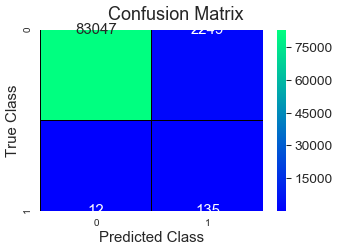

In [57]:
cm = confusion_matrix(y_test, y_smote)
sns.set(font_scale=1.5) #Adjust to fit
plt.figure(dpi=60)
sns.heatmap(cm,annot=True,fmt='d', cmap='winter',linecolor='black',linewidths=0.2)
plt.ylabel('True Class')
plt.yticks(fontsize = 12)
plt.xlabel('Predicted Class')
plt.xticks(fontsize=12)
plt.suptitle('Confusion Matrix')
plt.show()

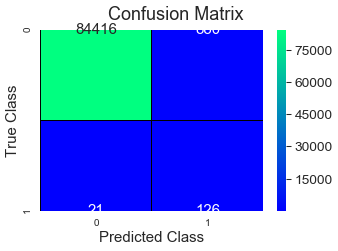

In [58]:
cm = confusion_matrix(y_test, y_blsmote)
sns.set(font_scale=1.5) #Adjust to fit
plt.figure(dpi=60)
sns.heatmap(cm,annot=True,fmt='d', cmap='winter',linecolor='black',linewidths=0.2)
plt.ylabel('True Class')
plt.yticks(fontsize = 12)
plt.xlabel('Predicted Class')
plt.xticks(fontsize=12)
plt.suptitle('Confusion Matrix')
plt.show()

# Decision Tree Classifier

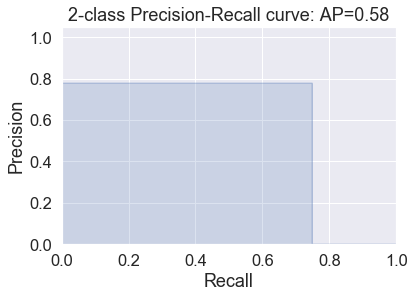

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.78      0.75      0.76       147

    accuracy                           1.00     85443
   macro avg       0.89      0.87      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85265    31]
 [   37   110]]


In [60]:
# Import the decision tree model from sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Fit a logistic regression model to our data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Obtain model predictions
y_predicted = model.predict(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',confusion_matrix(y_true = y_test, y_pred = y_predicted))

Precision = 0.77 The rate of true positive in all positive cases.

Recall = 0.76 The rate of true positive in all true cases.

F1-score = 0.76 False positives cases = 31.


# Decision Tree Classifier with SMOTE Data

In [61]:
# Import the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import BorderlineSMOTE

# Define which resampling method and which ML model to use in the pipeline
resampling = BorderlineSMOTE(kind='borderline-2',random_state=0) # instead SMOTE(kind='borderline2') 
model = DecisionTreeClassifier() 

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Decision Tree Classifier', model)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
y_predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',  confusion_matrix(y_true = y_test, y_pred = y_predicted))

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.56      0.73      0.64       147

    accuracy                           1.00     85443
   macro avg       0.78      0.87      0.82     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85211    85]
 [   39   108]]


# More Predictive models

 IMP Note::in below we use X_train and y_train same as logistic regression

# RandomForestClassifier

# Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation.

We will use as validation criterion GINI, which formula is GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC) [4]. Number of estimators is set to 100 and number of parallel jobs is set to 4.

We start by initializing the RandomForestClassifier.


In [91]:
# Import the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import BorderlineSMOTE

# Define which resampling method and which ML model to use in the pipeline

resampling = BorderlineSMOTE(kind='borderline-2',random_state=0) # instead SMOTE(kind='borderline2') 
model = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('Random Forest Classifier', model)])

pipeline.fit(X_train, y_train) 
y_predicted = pipeline.predict(X_test)


In [93]:
# Predict probabilities
probs = model.predict_proba(X_test)

print("AUC ROC score: ", roc_auc_score(y_test, probs[:,1]))
# Obtain the results from the classification report and confusion matrix 

print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',  confusion_matrix(y_true = y_test, y_pred = y_predicted))

AUC ROC score:  0.951704197435868
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.87      0.80      0.84       147

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85279    17]
 [   29   118]]


# Model adjustments

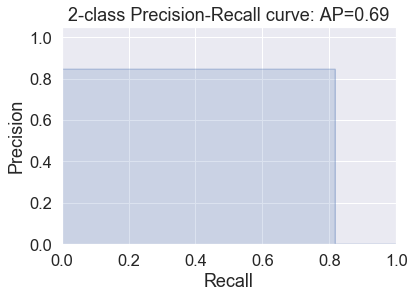

auc roc score:  0.972386276776702
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.85      0.82      0.83       147

    accuracy                           1.00     85443
   macro avg       0.92      0.91      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85274    22]
 [   27   120]]


In [97]:
# Import the Random Forest Classifier model from sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Define the model with balanced subsample
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12}, # 0: non-fraud , 1:fraud
                               criterion='entropy',
                               max_depth=10, # Change depth of model
                               min_samples_leaf=10, # Change the number of samples in leaf nodes
                               n_estimators=20, # Change the number of trees to use
                               n_jobs=-1, 
                               random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
y_predicted = model.predict(X_test)

# Calculate probs
probs = model.predict_proba(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# Print the roc auc score, the classification report and confusion matrix
print("auc roc score: ", roc_auc_score(y_test, probs[:,1]))
print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n', confusion_matrix(y_test, y_predicted))

Let's also visualize the features importance.

# Features importance¶

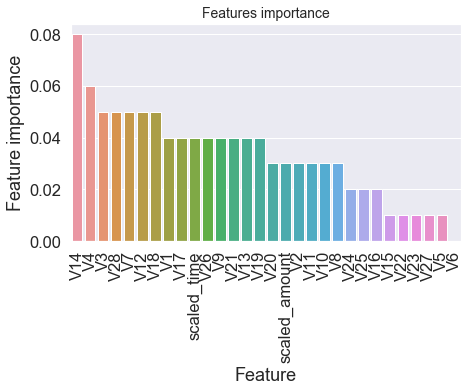

In [116]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

The most important features are V17, V12, V14, V10, V3, V16.

The most important features are V17, V12, V14, V10, V3, V16.

Let's calculate the ROC-AUC score

The ROC-AUC score obtained with RandomForrestClassifier is 97.2


# AdaBoostClassifier

Prepare the model

In [108]:
# Import the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import BorderlineSMOTE

# Define which resampling method and which ML model to use in the pipeline

resampling = BorderlineSMOTE(kind='borderline-2',random_state=0) # instead SMOTE(kind='borderline2') 
model = AdaBoostClassifier()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('AdaBoostClassifier', model)])

pipeline.fit(X_train, y_train) 
y_predicted = pipeline.predict(X_test)


In [109]:
# Predict probabilities
probs = model.predict_proba(X_test)

print("AUC ROC score: ", roc_auc_score(y_test, probs[:,1]))
# Obtain the results from the classification report and confusion matrix 

print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',  confusion_matrix(y_true = y_test, y_pred = y_predicted))

AUC ROC score:  0.9575215543917811
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     85296
           1       0.13      0.84      0.23       147

    accuracy                           0.99     85443
   macro avg       0.57      0.92      0.61     85443
weighted avg       1.00      0.99      0.99     85443

Confusion matrix:
 [[84469   827]
 [   23   124]]


# Model adjustments

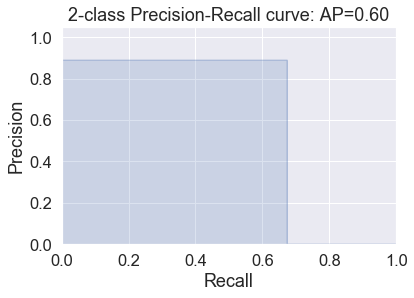

auc roc score:  0.9690309743293303
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.67      0.77       147

    accuracy                           1.00     85443
   macro avg       0.95      0.84      0.88     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85284    12]
 [   48    99]]


In [113]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

# Define the model with balanced subsample
model = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
y_predicted = model.predict(X_test)

# Calculate probs
probs = model.predict_proba(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# Print the roc auc score, the classification report and confusion matrix
print("auc roc score: ", roc_auc_score(y_test, probs[:,1]))
print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n', confusion_matrix(y_test, y_predicted))

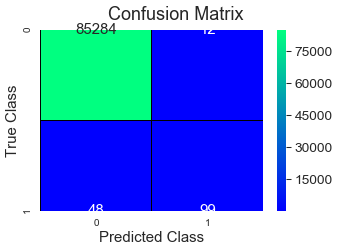

In [115]:
cm = confusion_matrix(y_test, y_predicted)
sns.set(font_scale=1.5) #Adjust to fit
plt.figure(dpi=60)
sns.heatmap(cm,annot=True,fmt='d', cmap='winter',linecolor='black',linewidths=0.2)
plt.ylabel('True Class')
plt.yticks(fontsize = 12)
plt.xlabel('Predicted Class')
plt.xticks(fontsize=12)
plt.suptitle('Confusion Matrix')
plt.show()

# Features importance

Features importance

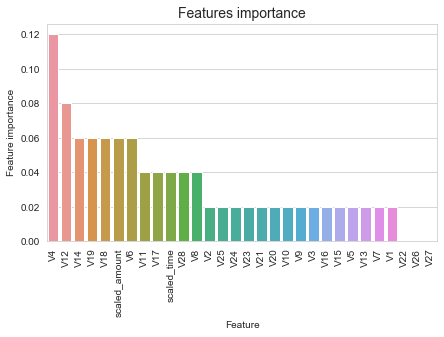

In [96]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The ROC-AUC score obtained with AdaBoostClassifier is 97.

# CatBoostClassifier

Prepare the model

In [119]:
from catboost import CatBoostClassifier
# Define which resampling method and which ML model to use in the pipeline

resampling = BorderlineSMOTE(kind='borderline-2',random_state=0) # instead SMOTE(kind='borderline2') 

model = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('CatBoostClassifier', model)])

pipeline.fit(X_train, y_train) 
y_predicted = pipeline.predict(X_test)

0:	total: 1s	remaining: 8m 20s
50:	total: 43.4s	remaining: 6m 22s
100:	total: 1m 25s	remaining: 5m 38s
150:	total: 2m 6s	remaining: 4m 52s
200:	total: 2m 47s	remaining: 4m 9s
250:	total: 3m 27s	remaining: 3m 25s
300:	total: 4m 10s	remaining: 2m 45s
350:	total: 4m 54s	remaining: 2m 5s
400:	total: 5m 38s	remaining: 1m 23s
450:	total: 6m 17s	remaining: 41s
499:	total: 6m 55s	remaining: 0us


In [120]:
# Predict probabilities
probs = model.predict_proba(X_test)

print("AUC ROC score: ", roc_auc_score(y_test, probs[:,1]))
# Obtain the results from the classification report and confusion matrix 

print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',  confusion_matrix(y_true = y_test, y_pred = y_predicted))

AUC ROC score:  0.9773079931653772
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.74      0.84      0.78       147

    accuracy                           1.00     85443
   macro avg       0.87      0.92      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85252    44]
 [   24   123]]


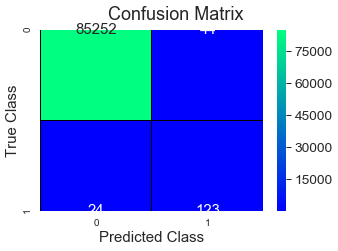

In [121]:
cm = confusion_matrix(y_test, y_predicted)
sns.set(font_scale=1.5) #Adjust to fit
plt.figure(dpi=60)
sns.heatmap(cm,annot=True,fmt='d', cmap='winter',linecolor='black',linewidths=0.2)
plt.ylabel('True Class')
plt.yticks(fontsize = 12)
plt.xlabel('Predicted Class')
plt.xticks(fontsize=12)
plt.suptitle('Confusion Matrix')
plt.show()

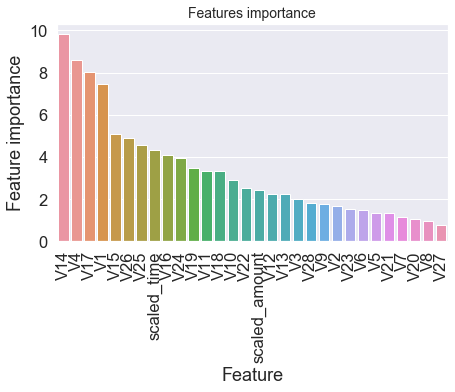

In [123]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

The ROC-AUC score obtained with CatBoostClassifier is 97.7

# XGBoost Classifier

Prepare the model

In [131]:
# Import the pipeline module we need for this from imblearn
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import BorderlineSMOTE

# Define which resampling method and which ML model to use in the pipeline

resampling = BorderlineSMOTE(kind='borderline-2',random_state=0) # instead SMOTE(kind='borderline2') 

model = XGBClassifier()

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
pipeline = Pipeline([('SMOTE', resampling), ('xgb', model)])

pipeline.fit(X_train, y_train) 
y_predicted = pipeline.predict(X_test)


In [132]:
# Predict probabilities
probs = model.predict_proba(X_test)

print("AUC ROC score: ", roc_auc_score(y_test, probs[:,1]))
# Obtain the results from the classification report and confusion matrix 

print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n',  confusion_matrix(y_true = y_test, y_pred = y_predicted))

AUC ROC score:  0.9591352626212744
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     85296
           1       0.22      0.84      0.34       147

    accuracy                           0.99     85443
   macro avg       0.61      0.92      0.67     85443
weighted avg       1.00      0.99      1.00     85443

Confusion matrix:
 [[84847   449]
 [   23   124]]


# Model adjustments

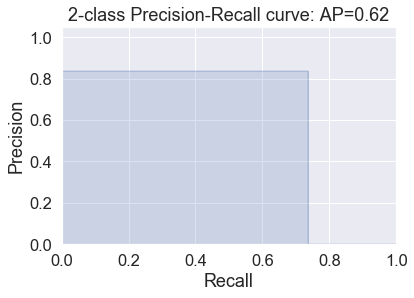

auc roc score:  0.9113640837126448
Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.84      0.73      0.78       147

    accuracy                           1.00     85443
   macro avg       0.92      0.87      0.89     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85275    21]
 [   39   108]]


In [184]:
from xgboost import XGBRegressor
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

params['random_state'] = RANDOM_STATE

# Define the model with balanced subsample
model = XGBClassifier(n_estimators=1000,learning_rate=0.05)

# Fit your training model to your training set
model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

# Obtain the predicted values and probabilities from the model 
y_predicted = model.predict(X_test)

# Calculate probs
probs = model.predict_proba(X_test)

# Calculate average precision 
average_precision = average_precision_score(y_test, y_predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, y_predicted)

# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

# Print the roc auc score, the classification report and confusion matrix
print("auc roc score: ", roc_auc_score(y_test, probs[:,1]))
print('Classifcation report:\n', classification_report(y_test, y_predicted))
print('Confusion matrix:\n', confusion_matrix(y_test, y_predicted))

# Traning XGBoost with DMatrix

In [187]:
 #Prepare the train and valid datasets
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [188]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.88101	valid-auc:0.88101
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.924419	valid-auc:0.924419
[100]	train-auc:0.951786	valid-auc:0.951786
[150]	train-auc:0.975403	valid-auc:0.975403
[200]	train-auc:0.988502	valid-auc:0.988502
[250]	train-auc:0.99283	valid-auc:0.99283
[300]	train-auc:0.994352	valid-auc:0.994352
[350]	train-auc:0.995574	valid-auc:0.995574
[400]	train-auc:0.996429	valid-auc:0.996429
[450]	train-auc:0.997367	valid-auc:0.997367
[500]	train-auc:0.998106	valid-auc:0.998106
[550]	train-auc:0.998659	valid-auc:0.998659
[600]	train-auc:0.998961	valid-auc:0.998961
[650]	train-auc:0.999235	valid-auc:0.999235
[700]	train-auc:0.99941	valid-auc:0.99941
[750]	train-auc:0.999572	valid-auc:0.999572
[800]	train-auc:0.999675	valid-auc:0.999675
[850]	train-auc:0.999724	valid-auc:0.999724
[900]	train-auc:0.999811	valid-auc:0.999811
[950]	train-auc:0.999849	valid

Plot variable importance

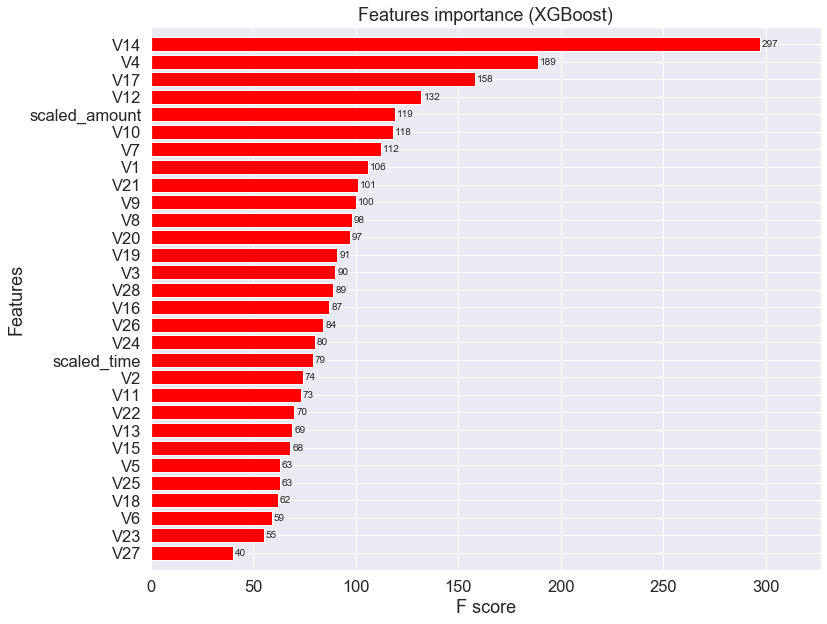

In [191]:
fig, (ax) = plt.subplots(ncols=1, figsize=(12,10))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="Red") 
plt.show()

# XGBoost + SMOTE


# Prediction on test set

We have used the train and validation sets for training and validation. 

now We will use the trained model now to predict the target value for the test set.


In [197]:
# Define the pipeline, tell it to combine SMOTE with the XGBClassifier model

resampling = BorderlineSMOTE(kind='borderline-2',random_state=0) # instead SMOTE(kind='borderline2') 

model = XGBClassifier() 

pipeline = Pipeline([('SMOTE', resampling), ('XGBClassifier', model)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
y_predicted = pipeline.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

print(accuracy_score(y_test, y_predicted))
print("AUC ROC score: ", roc_auc_score(y_test, probs[:,1]))

0.9944758493966738
AUC ROC score:  0.9591352626212744


The AUC score for the prediction on fresh data (test set) is 95.9

# Hyper-parameter tuning using Randomized search CV on various Classifiers

# Also splitting with Startified K-fold.

This is a simple timer function.I like to know how long things take :-)

In [229]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [230]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [231]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [241]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

folds = 5
param_comb = 5
i=1
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
     print('\n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = X.loc[train_index],X.loc[test_index]
     ytr,yvl = y[train_index],y[test_index]
     random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3, random_state=1001 )
     model.fit(xtr, ytr)
     print (model.best_params_)
     pred=model.predict(xvl)
     print('accuracy_score',accuracy_score(yvl,pred))
     i+=1
        
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
timer(start_time) # timing ends here for "start_time" variable


1 of kfold 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



{'V14': 23}
accuracy_score 0.999403110845827

2 of kfold 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



{'V14': 30}
accuracy_score 0.9995084442259752

3 of kfold 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



{'V14': 14}
accuracy_score 0.9995259914678464

4 of kfold 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



{'V14': 27}
accuracy_score 0.9996137708256526

5 of kfold 5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



{'V14': 4}
accuracy_score 0.999420656238479

 Time taken: 0 hours 0 minutes and 0.0 seconds.


Note::accuracy_score above is roc_auc_score as defined

In [245]:
# scores of RandomizedSearchCV 
scores = model.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_V14,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,42.526101,1.160938,0.062716,0.012863,4,{'V14': 4},0.28125,0.509091,0.948718,0.857143,0.833333,0.7,0.935065,0.84507,0.811594,0.757576,0.747882,0.196284,1
1,42.454034,0.770040,0.061972,0.008349,27,{'V14': 27},0.28125,0.509091,0.948718,0.857143,0.833333,0.7,0.935065,0.84507,0.811594,0.757576,0.747882,0.196284,1
2,42.374102,0.820068,0.061406,0.006256,24,{'V14': 24},0.28125,0.509091,0.948718,0.857143,0.833333,0.7,0.935065,0.84507,0.811594,0.757576,0.747882,0.196284,1
3,41.918959,0.317417,0.061231,0.009549,16,{'V14': 16},0.28125,0.509091,0.948718,0.857143,0.833333,0.7,0.935065,0.84507,0.811594,0.757576,0.747882,0.196284,1
4,42.746069,1.054502,0.051816,0.006285,22,{'V14': 22},0.28125,0.509091,0.948718,0.857143,0.833333,0.7,0.935065,0.84507,0.811594,0.757576,0.747882,0.196284,1


# Random Forest Tuning

In [251]:
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [253]:
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train, y_train)
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter = 100, cv = cross_val,
                                verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
clf_random.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning:

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 198.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 477.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_sp...
                     

In [255]:
# Scores of RandomizedSearchCV
scores = clf_random.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,245.355724,1.222831,1.468279,0.046193,200,auto,4,gini,"{'n_estimators': 200, 'max_features': 'auto', ...",0.930871,0.961074,0.907471,0.980358,0.959428,0.947840,0.025630,57
1,628.040362,5.280749,3.709611,0.365651,500,auto,4,gini,"{'n_estimators': 500, 'max_features': 'auto', ...",0.976405,0.956896,0.924890,0.987432,0.966171,0.962359,0.021327,3
2,253.696800,10.178652,1.453308,0.113540,200,sqrt,4,gini,"{'n_estimators': 200, 'max_features': 'sqrt', ...",0.969111,0.949495,0.929257,0.982503,0.959368,0.957947,0.018023,24
3,651.468758,4.758251,4.241344,0.602620,500,sqrt,4,gini,"{'n_estimators': 500, 'max_features': 'sqrt', ...",0.975350,0.953742,0.914379,0.986837,0.957562,0.957574,0.024709,26
4,213.315763,4.943957,1.412100,0.172248,200,log2,4,gini,"{'n_estimators': 200, 'max_features': 'log2', ...",0.936441,0.960326,0.922042,0.982591,0.949850,0.950250,0.020659,50


In [258]:
clf_random.best_score_

0.9643191275665066

In [259]:
clf_random.best_params_

{'n_estimators': 200,
 'max_features': 'log2',
 'max_depth': 8,
 'criterion': 'entropy'}

In [260]:
clf_random.best_index_

58

Text(0.5, 1, 'Random Forest Tuning with Randomized SearchCV')

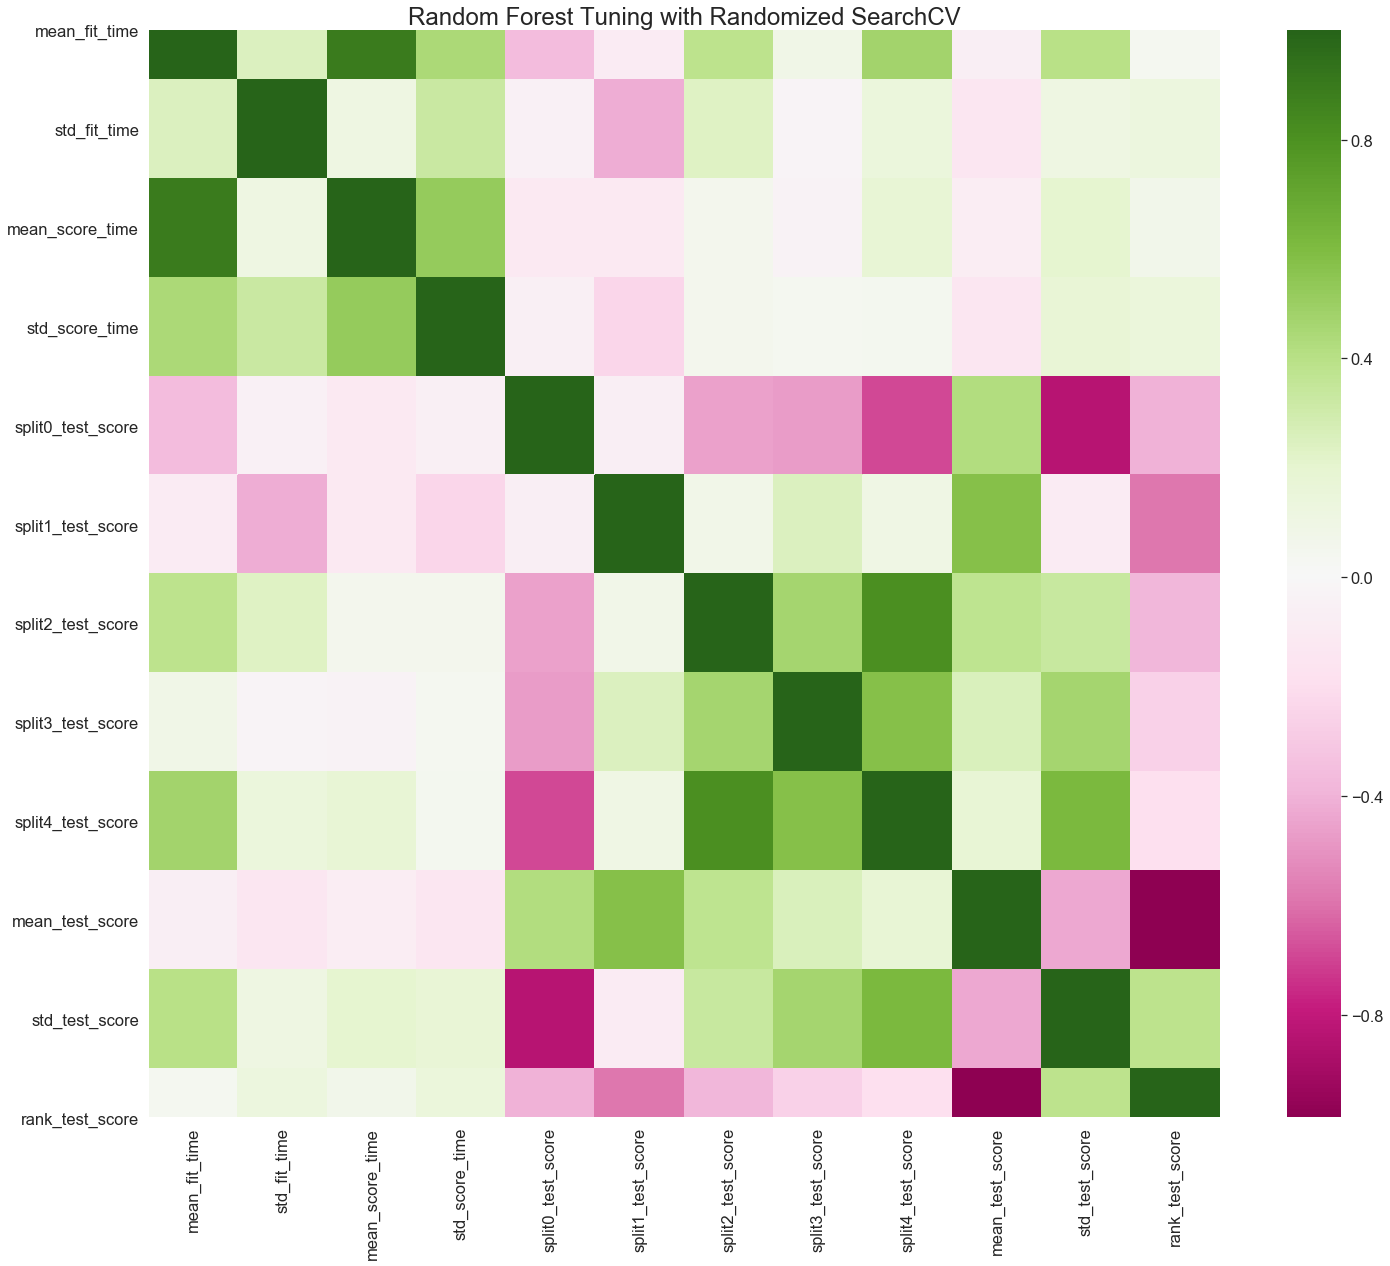

In [281]:
corr = pd.DataFrame(scores).corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='PiYG', annot_kws={'size':20})
ax.set_title("Random Forest Tuning with Randomized SearchCV", fontsize=24)

In [283]:
from matplotlib      import pyplot as plt
from IPython.display import display

# XGBoost Tuning

In [305]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [306]:
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_train, y_train)


dlf = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1) 


dlf_random = RandomizedSearchCV(estimator = dlf, param_distributions = params, n_iter =30 , cv = cross_val,
                                verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
dlf_random.fit(X, y)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 64.8min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=1,
                                           objective='bin...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='deprecat

In [307]:
# scores of RandomizedSearchCV
scores = dlf_random.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,161.740802,1.748705,0.359621,0.078377,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.964696,0.932621,0.894526,0.942907,0.912162,0.929382,0.024298,2
1,170.915148,1.752855,0.386619,0.033411,1,1,3,2,0.8,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",0.914012,0.928886,0.896631,0.933374,0.897584,0.914097,0.015284,27
2,192.069672,0.919965,0.340090,0.016902,0.8,10,3,5,1,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.954039,0.929159,0.897541,0.933543,0.897769,0.922410,0.021888,18
3,122.673253,2.008621,0.326847,0.028258,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.956310,0.928533,0.901199,0.943366,0.902394,0.926360,0.021901,5
4,151.804160,1.660657,0.392549,0.038358,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.956364,0.931902,0.894581,0.943281,0.912535,0.927733,0.021950,4


In [309]:
dlf_random.best_score_

0.9451835773347879

In [310]:
dlf_random.best_params_

{'subsample': 1.0,
 'min_child_weight': 5,
 'max_depth': 5,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [311]:
dlf_random.best_index_

5

Text(0.5, 1, 'XGBoost Tuning with Randomized SearchCV')

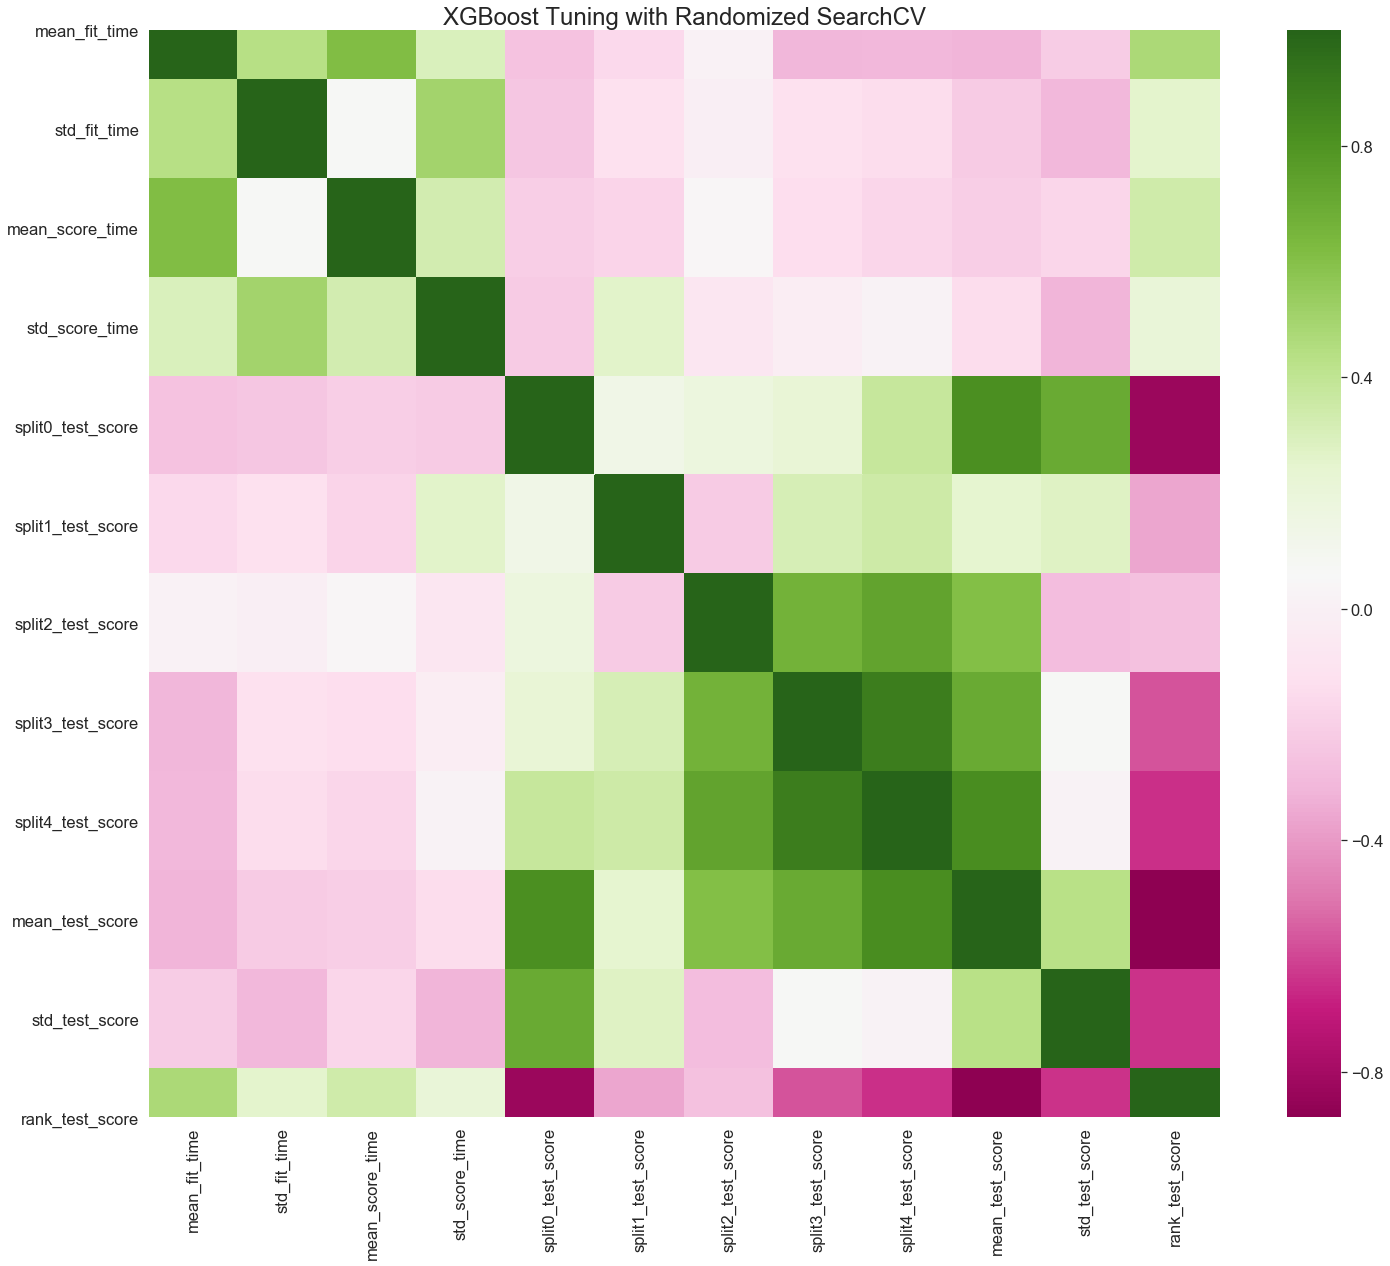

In [312]:
corr = pd.DataFrame(scores).corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='PiYG', annot_kws={'size':20})
ax.set_title("XGBoost Tuning with Randomized SearchCV", fontsize=24)

# XGBoost tuning with Smote Data

In [382]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [389]:
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_smote, y_smote)

elf = XGBClassifier(learning_rate=0.02, n_estimators=50, objective='binary:logistic',
                    silent=True, nthread=1) 

elf_random = RandomizedSearchCV(estimator = elf, param_distributions = params, n_iter =30 , cv = cross_val,
                                verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
elf_random.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 51.7min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=50,
                                           n_jobs=1, nthread=1,
                                           objective='bina...
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=True, subsample=1,
                                           verbosity=1),
                   iid='deprecat

In [390]:
# scores of RandomizedSearchCV
scores = elf_random.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,194.338055,0.940531,1.377200,1.408310,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.992698,0.993535,0.993136,0.993196,0.993023,0.993117,0.000270,11
1,167.379683,26.825397,0.813588,0.399769,1,1,3,2,0.8,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",0.985698,0.986775,0.986460,0.986211,0.985855,0.986200,0.000392,21
2,155.168011,1.514478,0.668320,0.568682,0.8,10,3,5,1,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.985986,0.986806,0.986261,0.984827,0.985133,0.985803,0.000728,25
3,98.403392,0.820788,0.365722,0.051999,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.987358,0.988389,0.988026,0.987751,0.987531,0.987811,0.000365,20
4,128.969035,1.577299,0.475455,0.063850,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.992786,0.993605,0.993109,0.993189,0.993007,0.993139,0.000269,9


In [391]:
elf_random.best_score_

0.9965731348014387

In [392]:
elf_random.best_params_

{'subsample': 0.6,
 'min_child_weight': 10,
 'max_depth': 5,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [393]:
elf_random.best_index_

11

Text(0.5, 1, 'XGBoost Tuning with Randomized SearchCV')

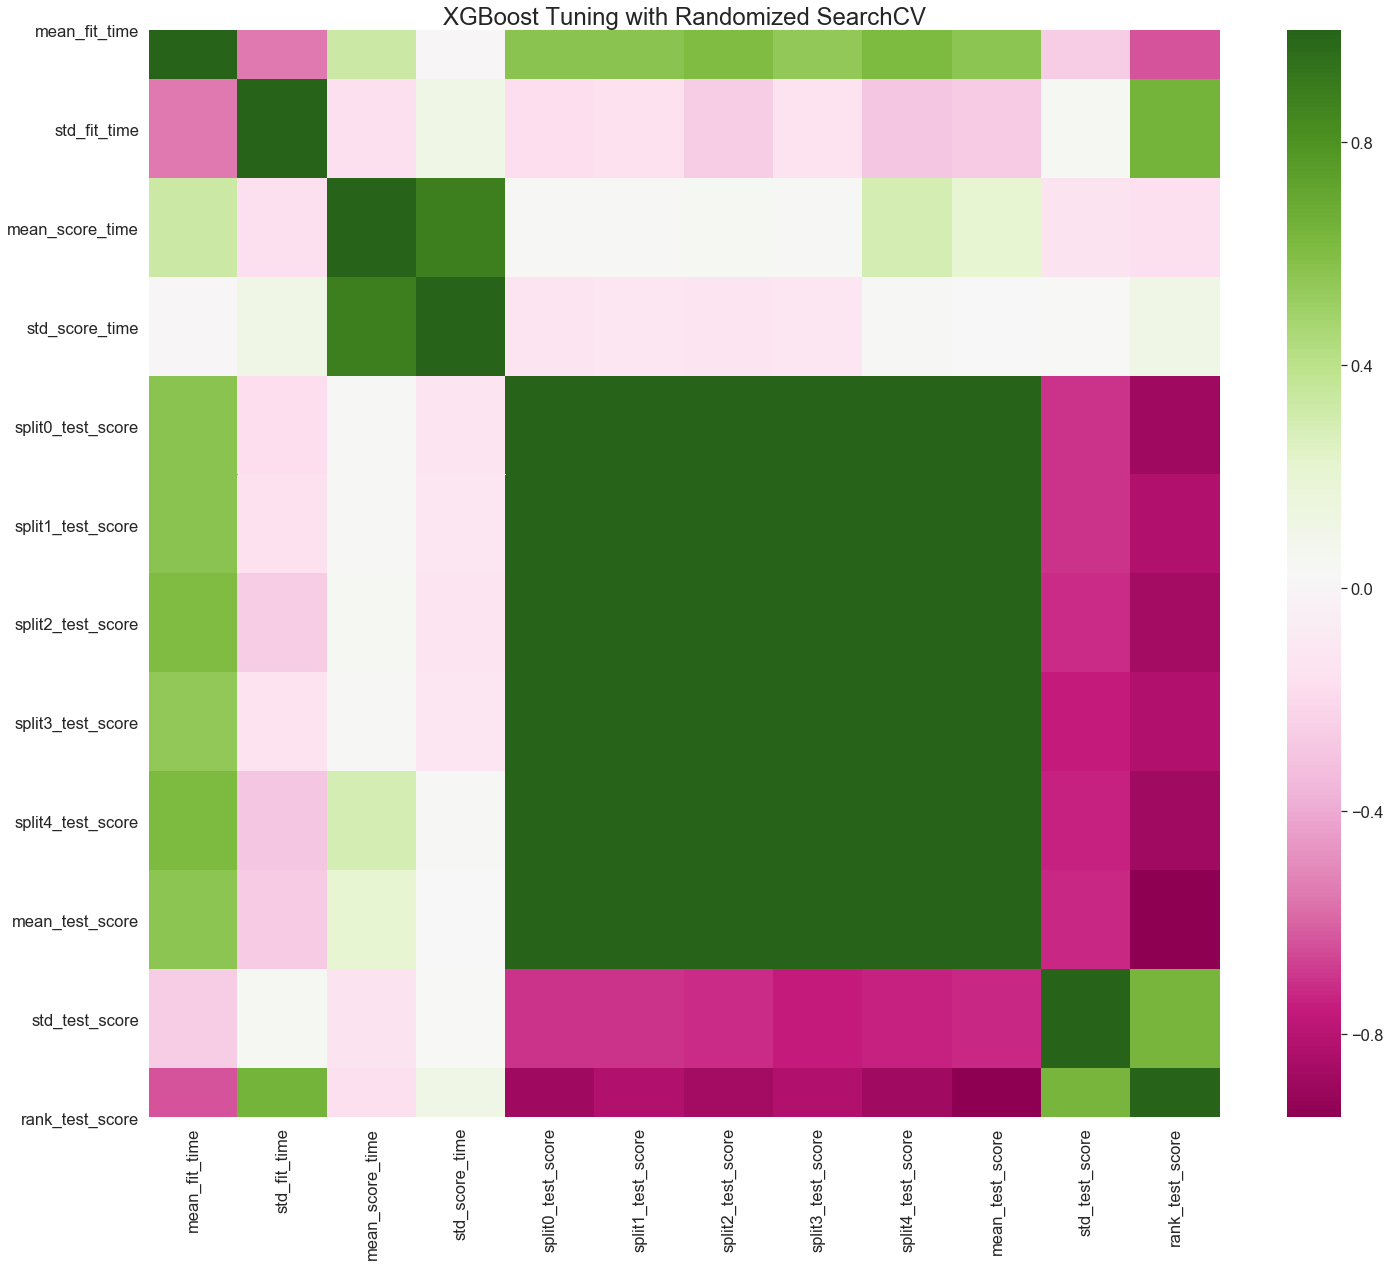

In [394]:
corr = pd.DataFrame(scores).corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='PiYG', annot_kws={'size':20})
ax.set_title("XGBoost Tuning with Randomized SearchCV", fontsize=24)

# LightGBM Tuning

In [356]:
import lightgbm as lgb
# A parameter grid for XGBoost
params = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [358]:
from lightgbm import LGBMClassifier
cross_val = StratifiedKFold(n_splits=10)
index_iterator = cross_val.split(X_train, y_train)


glf = LGBMClassifier(learning_rate=0.02, n_estimators=100,silent=True, nthread=1) 

glf_random = RandomizedSearchCV(estimator = glf, param_distributions = params, n_iter =60 , cv = cross_val,
                                verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
glf_random.fit(X, y)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 15.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.02, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            nthread=1, num_leaves...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161A3B28448>,
                                        'reg_alpha': [0, 0.1, 1, 2

In [359]:
# scores of RandomizedSearchCV
scores = glf_random.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_num_leaves,param_reg_alpha,param_reg_lambda,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,8.054306,0.450563,0.184836,0.049582,0.624724,448,1000,26,10,0.1,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,45
1,10.594224,0.704058,0.724878,0.128828,0.43485,187,1,41,50,100,...,0.907125,0.933560,0.950152,0.996368,0.988435,0.979080,0.975174,0.971686,0.029656,39
2,11.514095,0.539634,0.573005,0.113884,0.433847,443,10,7,5,0,...,0.918246,0.938222,0.958989,0.995392,0.986181,0.979672,0.973982,0.974239,0.026228,26
3,10.275339,1.035500,0.158090,0.021478,0.714854,335,10000,32,1,5,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,45
4,11.493178,0.220837,0.509119,0.082615,0.755449,230,1,12,5,0,...,0.938238,0.949708,0.953191,0.996298,0.984492,0.985011,0.969616,0.976988,0.021595,4


In [360]:
glf_random.best_score_

0.9782933440374311

In [361]:
glf_random.best_params_

{'colsample_bytree': 0.4242601537230588,
 'min_child_samples': 306,
 'min_child_weight': 0.01,
 'num_leaves': 37,
 'reg_alpha': 10,
 'reg_lambda': 0,
 'subsample': 0.45148478486106136}

In [362]:
glf_random.best_index_

16

Text(0.5, 1, 'LightGBM Tuning with Randomized SearchCV')

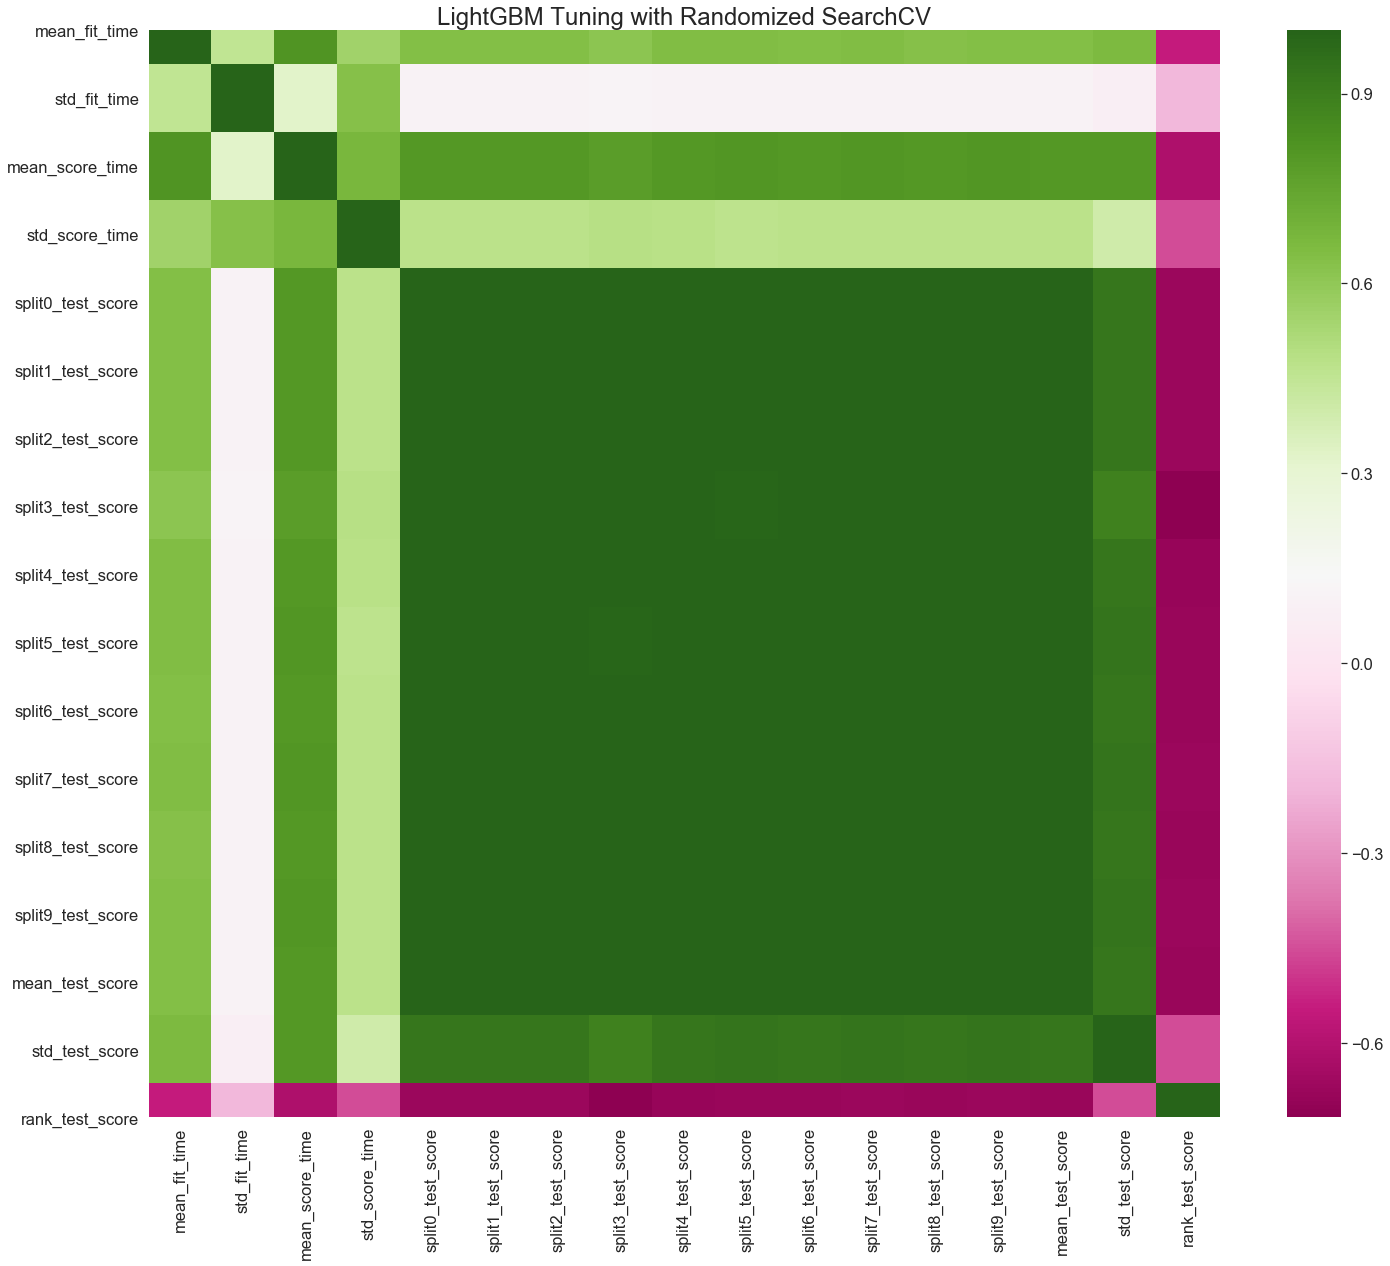

In [363]:
corr = pd.DataFrame(scores).corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='PiYG', annot_kws={'size':20})
ax.set_title("LightGBM Tuning with Randomized SearchCV", fontsize=24)

# LightGBM Tuning with Smote Data

In [367]:
import lightgbm as lgb
# A parameter grid for XGBoost
params = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [371]:
from lightgbm import LGBMClassifier
cross_val = StratifiedKFold(n_splits=5)
index_iterator = cross_val.split(X_smote, y_smote)


flf = LGBMClassifier(learning_rate=0.02, n_estimators=500,silent=True, nthread=1) 

flf_random = RandomizedSearchCV(estimator = flf, param_distributions = params, n_iter =30 , cv = cross_val,
                                verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')
flf_random.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 31.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.02, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=500, n_jobs=-1,
                                            nthread=1, num_leaves=...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161A422A6C8>,
                                        'reg_alpha': [0, 0.1, 1, 2

In [372]:
# scores of RandomizedSearchCV
scores = flf_random.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_min_child_samples,param_min_child_weight,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,86.943525,1.377213,12.847317,0.513462,0.624724,448,1000,26,10,0.1,0.324796,"{'colsample_bytree': 0.6247240713084175, 'min_...",0.999563,0.999629,0.999557,0.999612,0.999614,0.999595,0.000029,19
1,95.295216,4.164279,18.205095,4.253058,0.43485,187,1,41,50,100,0.720711,"{'colsample_bytree': 0.4348501673009197, 'min_...",0.999858,0.999908,0.999848,0.999900,0.999912,0.999885,0.000027,13
2,65.264127,0.909239,10.255866,0.558996,0.433847,443,10,7,5,0,0.443394,"{'colsample_bytree': 0.4338469474162602, 'min_...",0.999333,0.999402,0.999337,0.999382,0.999377,0.999366,0.000027,25
3,54.793413,3.628945,2.847106,0.186513,0.714854,335,10000,32,1,5,0.611388,"{'colsample_bytree': 0.7148538589793427, 'min_...",0.984454,0.985371,0.984877,0.985042,0.984465,0.984842,0.000350,29
4,91.282561,3.490680,10.308883,1.664731,0.755449,230,1,12,5,0,0.252041,"{'colsample_bytree': 0.7554487413172255, 'min_...",0.999811,0.999887,0.999820,0.999846,0.999886,0.999850,0.000032,17


In [373]:
flf_random.best_score_

0.9999714580187253

In [374]:
flf_random.best_params_

{'colsample_bytree': 0.8741053243187233,
 'min_child_samples': 478,
 'min_child_weight': 1,
 'num_leaves': 47,
 'reg_alpha': 10,
 'reg_lambda': 0.1,
 'subsample': 0.2926952476201038}

In [375]:
flf_random.best_index_

12

Text(0.5, 1, 'LightGBM Tuning with Randomized SearchCV')

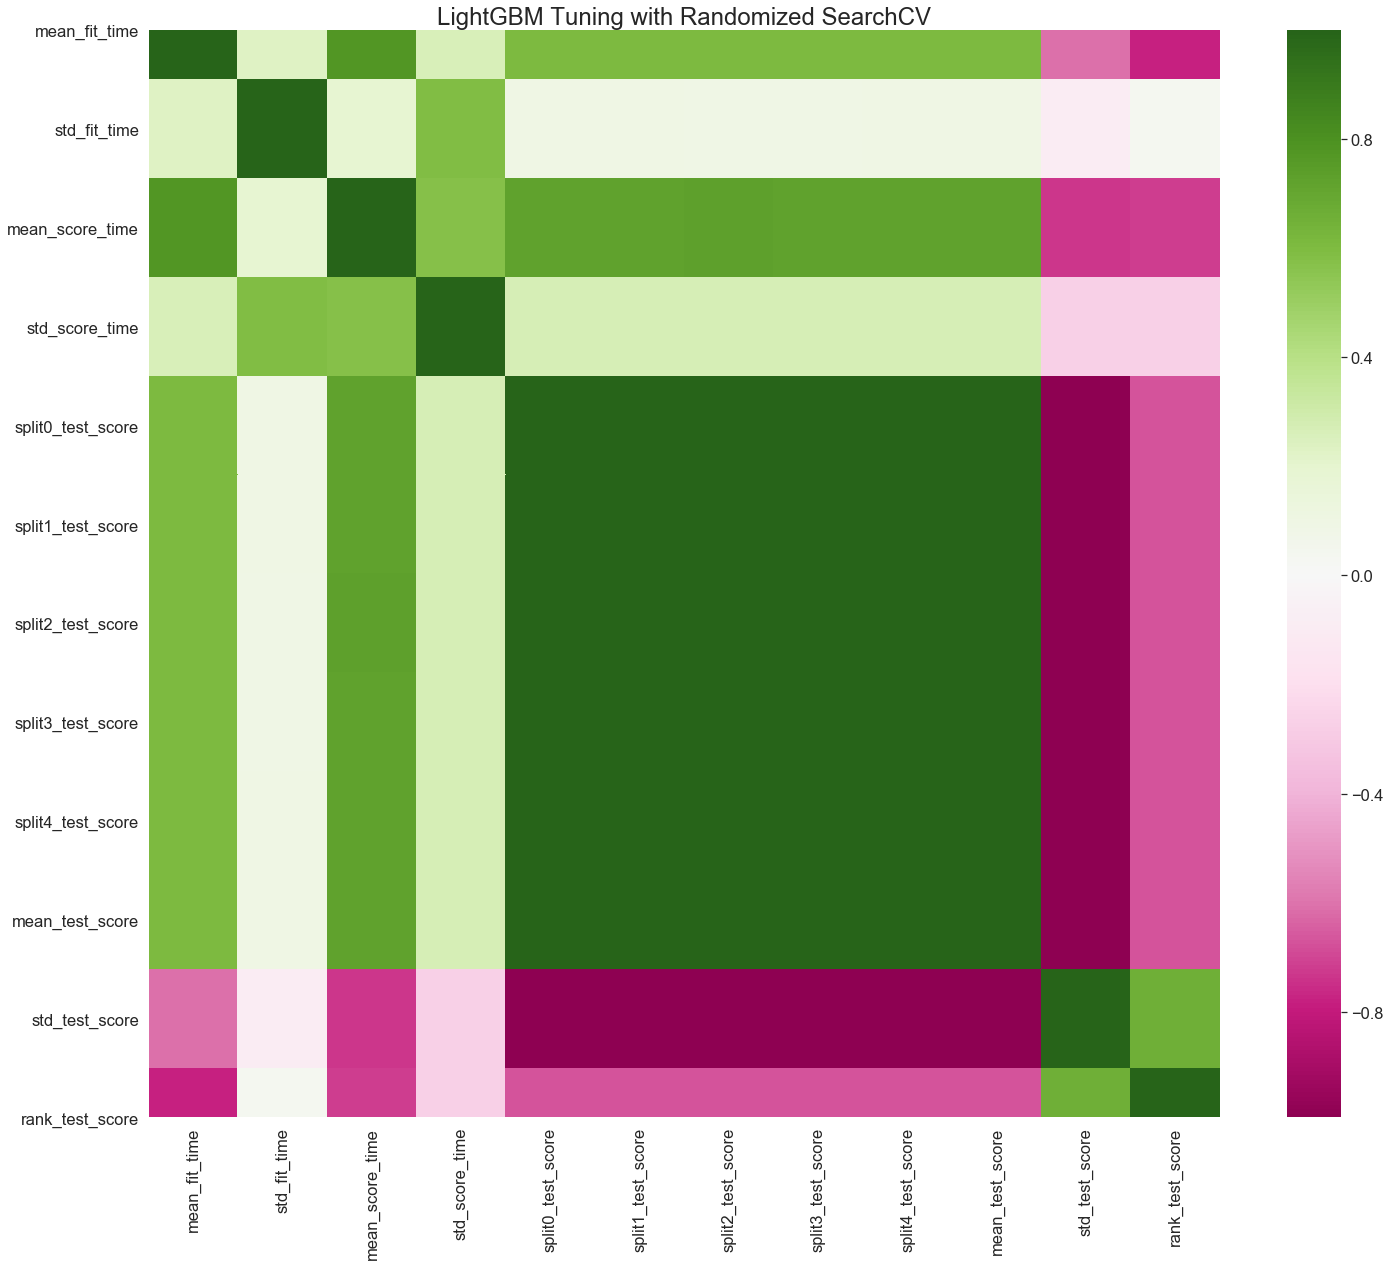

In [376]:
corr = pd.DataFrame(scores).corr() 

# Plot heatmap of correlation
f, ax = plt.subplots(1, 1, figsize=(24,20))
sns.heatmap(corr, cmap='PiYG', annot_kws={'size':20})
ax.set_title("LightGBM Tuning with Randomized SearchCV", fontsize=24)

# Conclusions::

1.We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features.

2.We have used Plotly library in EDA in order to get best Visulaization which wont be visible if library is not already installed.

3.There are few important inferences during EDA phase which are mentioned on that particular step.

4.We have done Model Building on both Balanced and imbalanced Data in starting phase.

5.Executed Logistic Regression,Decision Tree Classifier, Random Forest, Adaboost Classifier, Catboost Classifier, XGBoost Classifier, LightGBM Classifier.

6.In Intial Model-Bulding Phase we have compared scores with both Balanced and Imbalanced data without any k-fold or Tuning Hyperparameters.

7.We have handled Skewness in Logistic Regression using PowerTransformer Method.

8.Key Scoring Metric used in each ensemble is Roc_Auc Score.

9.Without Tuning Hyperparameters XGBoost==99.99 in last round(using D-Matrix on unbalanced data), Catboost==97.7,Randomforest==97.2 AdaBoost==96.9, XGBoost ==95.2(on balanced)

10.we have used Stratified K-fold cross Validation to optimize model Robustness.

11.We have done Hyperparameter Tuning using Randomized Search CV for each Classifier.

12. we have done tuning and cross validation on both balanced and imbalanced Data.

13. Final scores on balanced Data using LIGHTGBM is approximately 99.99.

14.followed By XGBoost which is 99.6.

15. The best results thus are obtained by LightGBM and XGboost and then its followed by Random forest.

16.In each Model V14,V12,V17 are found to be most Important features to detect  Fraud Transaction.

17. Overall using above mentioned scores on test and validation set in Best classifiers ,, it can be identified whether a Transaction is Fruad or not.and actions can be taken to avoid the same.

-------------------It End Here------------------Stay Safe--------Stay Healthy-----------------------------------------